# Configuration 



Dataset available on kaggle : https://www.kaggle.com/paultimothymooney/chest-xray-pneumonia

In [1]:
import torch 
import numpy as np 
import matplotlib.pyplot as plt 
import os 
from tqdm.notebook import tqdm 

In [2]:
class CFG:
    
    epochs = 1                                         # No. of epochs of training the model 
    lr = 0.001                                         # Learning rate 
    batch_size = 16                                    # Batch Size For Dataset 
    
    model_name = 'tf_efficientnet_b4_ns'               # Model name (We are going to import model from timm)
    img_size = 224
    
    # Going to be use for loading dataset 
    DATA_DIR = "chest_xray_data"                       # Data Directory 
    TEST = 'test'                                      # Test folder name in data directory 
    TRAIN = 'train'                                    # Train folder name in data directory 
    VAL ='val'                                         # Valid folder name in data directory 
    
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
print("On which device we are on : {}".format(device))

On which device we are on : cpu


/home/rhyme/.local/lib/python3.6/site-packages/torch/cuda/__init__.py:52: UserWarning: CUDA initialization: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx (Triggered internally at  /pytorch/c10/cuda/CUDAFunctions.cpp:100.)
  return torch._C._cuda_getDeviceCount() > 0


# Image Transformation and Load Dataset 

In [3]:
from torchvision import transforms as T, datasets
from helper import show_image

In [4]:
train_transform = T.Compose([
    T.Resize(size = (CFG.img_size, CFG.img_size)),
    T.RandomRotation(degrees = (-20, +20)),
    T.ToTensor(), # (h,w,c) -> (c,h,w)
    T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

valid_transform = T.Compose([
    T.Resize(size = (CFG.img_size, CFG.img_size)),
    T.ToTensor(), # (h,w,c) -> (c,h,w)
    T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

test_transform = T.Compose([
    T.Resize(size = (CFG.img_size, CFG.img_size)),
    T.ToTensor(), # (h,w,c) -> (c,h,w)
    T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

In [5]:
train_path = os.path.join(CFG.DATA_DIR, CFG.TRAIN)
valid_path = os.path.join(CFG.DATA_DIR, CFG.VAL)
test_path = os.path.join(CFG.DATA_DIR, CFG.TEST)

trainset = datasets.ImageFolder(train_path, transform = train_transform)
validset = datasets.ImageFolder(valid_path, transform = valid_transform)
testset = datasets.ImageFolder(test_path, transform = test_transform)



In [6]:
print("Trainset Size : {}".format(len(trainset)))
print("Validset Size : {}".format(len(validset)))
print("Testset Size : {}".format(len(testset)))

Trainset Size : 5216
Validset Size : 16
Testset Size : 624


{'NORMAL': 0, 'PNEUMONIA': 1}


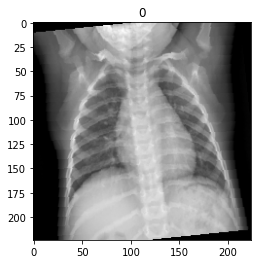

In [7]:
image, label = trainset[2]

print(trainset.class_to_idx)
show_image(image, label)

# Load Dataset into Batches 

In [8]:
from torch.utils.data import DataLoader 
from torchvision.utils import make_grid
from helper import show_grid

In [9]:
trainloader = DataLoader(trainset, batch_size=CFG.batch_size, shuffle=True)
validloader = DataLoader(validset, batch_size=CFG.batch_size, shuffle=True)
testloader = DataLoader(testset, batch_size=CFG.batch_size, shuffle=True)

In [10]:
print("No. of batches in trainloader : {}".format(len(trainloader)))
print("No. of Total examples : {}".format(len(trainloader.dataset)))

No. of batches in trainloader : 326
No. of Total examples : 5216


In [11]:
class_name = ['Normal', 'Pneumonia']

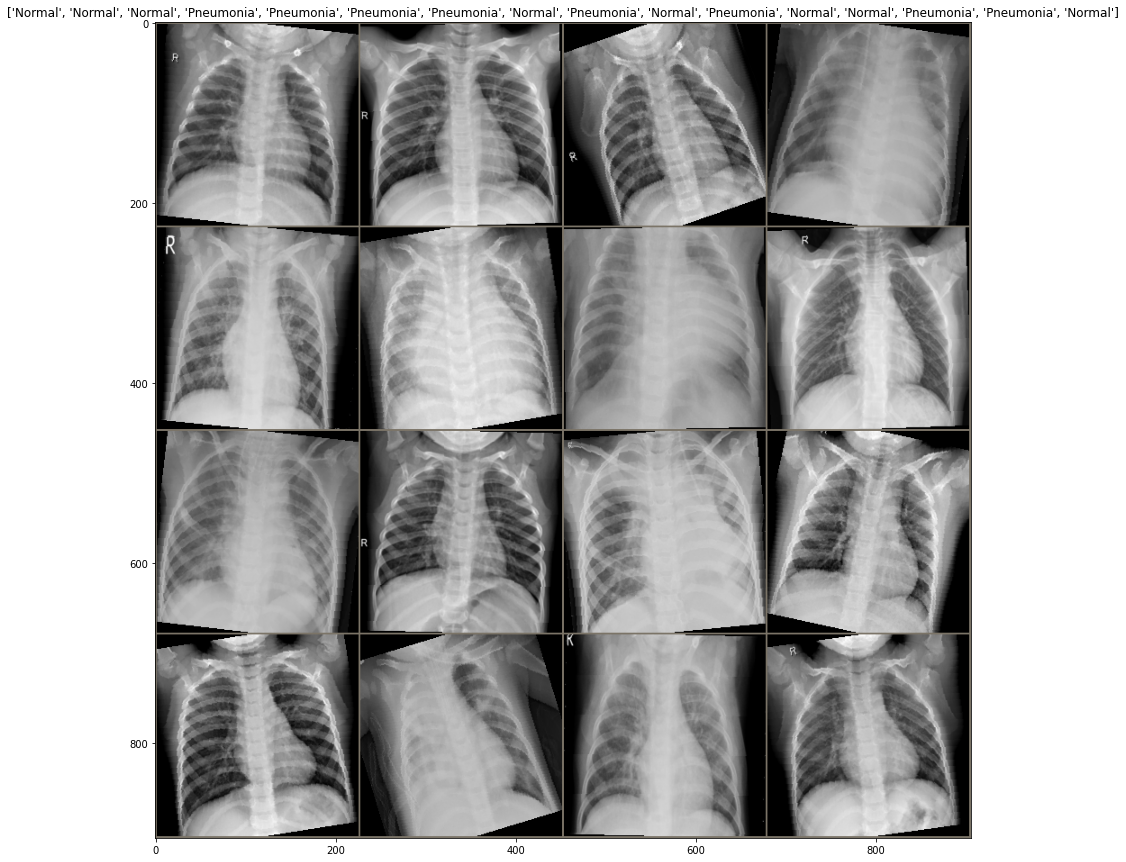

In [12]:
dataiter = iter(trainloader)
images, labels = dataiter.next()

out = make_grid(images, nrow=4)

show_grid(out, title=[class_name[x] for x in labels])

# Fine Tuning EfficientNet Model 

In [13]:
from torch import nn 
import torch.nn.functional as F
import timm 

model = timm.create_model(CFG.model_name, pretrained=True)

# last layer to replace: 

for param in model.parameters():
    param.requires_grad = False
    
model.classifier = nn.Sequential(
        
    nn.Linear(in_features = 1792, out_features = 625), 
    nn.ReLU(),
    nn.Dropout(p=0.3),
    
    nn.Linear(in_features = 625, out_features = 256), 
    nn.ReLU(),
    
    nn.Linear(in_features = 256, out_features = 2), 

)


In [14]:
from torchsummary import summary 

summary(model, input_size = (3,224,224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
        Conv2dSame-1         [-1, 48, 112, 112]           1,296
       BatchNorm2d-2         [-1, 48, 112, 112]              96
              SiLU-3         [-1, 48, 112, 112]               0
            Conv2d-4         [-1, 48, 112, 112]             432
       BatchNorm2d-5         [-1, 48, 112, 112]              96
              SiLU-6         [-1, 48, 112, 112]               0
            Conv2d-7             [-1, 12, 1, 1]             588
              SiLU-8             [-1, 12, 1, 1]               0
            Conv2d-9             [-1, 48, 1, 1]             624
    SqueezeExcite-10         [-1, 48, 112, 112]               0
           Conv2d-11         [-1, 24, 112, 112]           1,152
      BatchNorm2d-12         [-1, 24, 112, 112]              48
         Identity-13         [-1, 24, 112, 112]               0
DepthwiseSeparableConv-14         [-1, 

# Build a Simple Trainer

In [15]:
from helper import accuracy
from tqdm import tqdm

In [16]:
class PneumoniaTrainer():
    
    def __init__(self, criterion, optimizer, scheduler):
        self.criterion = criterion
        self.optimizer = optimizer
        self.scheduler = scheduler
    
    def train_batch_loop(self, model, trainloader):
        
        train_acc = 0.0
        train_loss = 0.0
        
        for images, labels in tqdm(trainloader):
            images = images.to(device)
            labels = labels.to(device)
            
            logits = model(images)
            loss = criterion(logits, labels)
            
            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()
            
            train_loss +=loss.item()
            train_acc += accuracy(logits, labels)
            
        return train_acc / len(trainloader), train_loss / len(trainloader)
    
    def valid_batch_loop(self, model, validloader):
        
        valid_acc = 0.0
        valid_loss = 0.0
        
        for images, labels in tqdm(validloader):
            images = images.to(device)
            labels = labels.to(device)
            
            logits = model(images)
            loss = criterion(logits, labels)
            
            #No training here
            
            valid_loss +=loss.item()
            valid_acc += accuracy(logits, labels)
            
        return valid_acc / len(validloader), valid_loss / len(validloader)
            
        
    def fit(self, model, trainloader, validloader, epochs):
        
        model = model.to(device)
        valid_min_loss = np.Inf
        
        for i in range(epochs):
            
            model.train() #turn on dropout
            avg_train_acc, avg_train_loss = self.train_batch_loop(model, trainloader)
            
            model.eval() #turn off dropout batch norm
            
            avg_valid_acc, avg_valid_loss = self.valid_batch_loop(model, validloader)
            
            if avg_valid_loss <= valid_min_loss:
                print("Valid loss decreased {} --> {}".format(valid_min_loss, avg_valid_loss) )
                
                torch.save(model.state_dict(), 'PneumoniaModel.pt')
                
                valid_min_loss = avg_valid_loss
                
                
            print("Epoch : {} Train Loss: {} Train Acc {}".format(i+1, avg_train_loss, avg_train_acc))
            print("Epoch : {} Valid Loss: {} Valid Acc {}".format(i+1, avg_valid_loss, avg_valid_acc))
            

# Training Model 


Trained on google colab : https://colab.research.google.com/drive/1C5nNPj7OLYMGnNvWBU5W2zSXfgWDdXCo?usp=sharing

In [17]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = CFG.lr)
Scheduler = None

trainer = PneumoniaTrainer(criterion, optimizer, Scheduler)
trainer.fit(model, trainloader, validloader, 1)


100%|██████████| 1/1 [00:04<00:00,  4.46s/it]

Valid loss decreased inf --> 0.8267558813095093
Epoch : 1 Train Loss: 0.26129257867535566 Train Acc 0.8909125924110413
Epoch : 1 Valid Loss: 0.8267558813095093 Valid Acc 0.5


# Plot Results 

In [18]:
from helper import view_classify

model.load_state_dict(torch.load('ColabPneumoniaModel.pt', map_location='cpu'))

avg_test_acc, avg_test_loss = trainer.valid_batch_loop(model, testloader)

print("Test Loss : {}".format(avg_test_acc))
print("Test Acc : {}".format(avg_test_loss))

100%|██████████| 39/39 [02:56<00:00,  4.51s/it]


NameError: name 'avg_test_acc' is not defined

In [19]:
print("Test Loss : {}".format(acg_test_acc))
print("Test Acc : {}".format(avg_test_loss))

Test Loss : 0.879807710647583
Test Acc : 0.2958922414825513


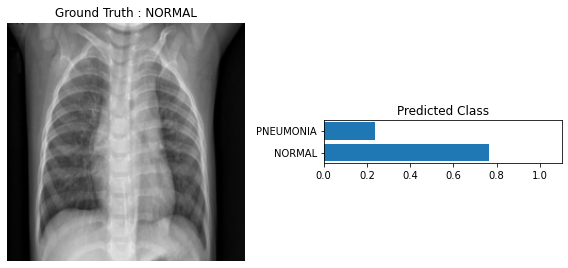

In [28]:
image,label = testset[40]

logits = model(image.unsqueeze(0)) # Back from tensor to image
ps = F.softmax(logits,dim = 1)


view_classify(image,ps,label)